In [1]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


#Dataset Exploration & Augmentation

**Load images, confirm class counts, and visualize a few samples per class.**


In [3]:
# Define the base path to your dataset on Google Drive
# MAKE SURE THIS PATH IS CORRECT FOR YOUR DATASET LOCATION
data_path = "/content/drive/MyDrive/SDS-CP031-myconet/input"

images = []
labels = []


# Iterate through subfolders to collect image paths and labels
print(f"Loading images from: {data_path}")
if os.path.exists(data_path):
    for subfolder in os.listdir(data_path):
        subfolder_path = os.path.join(data_path, subfolder)

        # Check if the item in the data_path is a directory
        if os.path.isdir(subfolder_path):
            print(f"Processing subfolder: {subfolder}")
            for image_filename in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_filename)

                # Optional: Add a check to ensure it's a file and potentially an image file type
                # You might want to refine this check based on actual file extensions
                if os.path.isfile(image_path):
                     # Basic check for common image extensions
                    if image_filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                        images.append(image_path)
                        labels.append(subfolder)
                    else:
                        print(f"Skipping non-image file: {image_path}")
                else:
                    print(f"Skipping non-file item: {image_path}")
else:
    print(f"Error: Data path not found at {data_path}")
    get_ipython().exiter() # Exit if the data path is incorrect


# Create a DataFrame from the collected data
data = pd.DataFrame({'image': images, 'label': labels})

Loading images from: /content/drive/MyDrive/SDS-CP031-myconet/input
Processing subfolder: H6
Processing subfolder: H5
Processing subfolder: H3
Processing subfolder: H2
Processing subfolder: H1


In [4]:
# Confirm Class Counts
print("\nClass Distribution:")
print(data['label'].value_counts())


Class Distribution:
label
H1    4404
H2    2334
H3     819
H5     818
H6     739
Name: count, dtype: int64


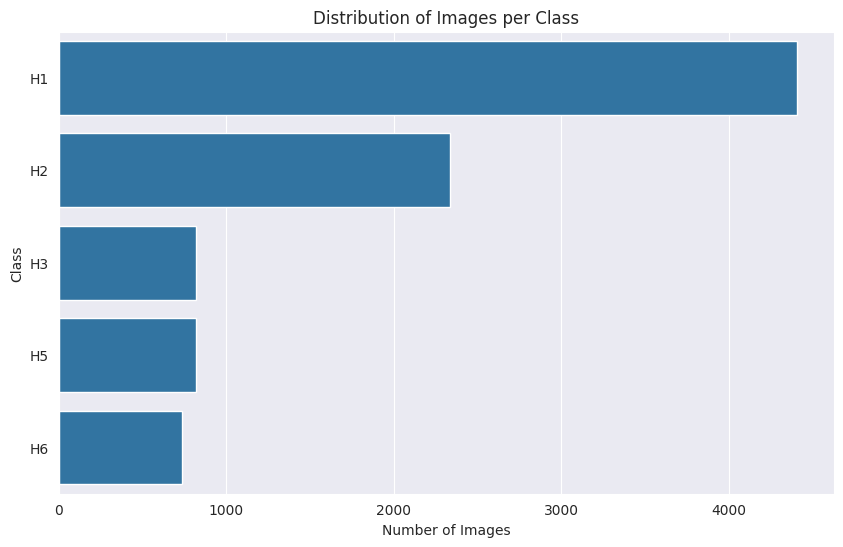

In [5]:
# Visualize Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=data, y='label', order=data['label'].value_counts().index)
plt.title('Distribution of Images per Class')
plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.show()

In [6]:
# Visualize a few samples per class
print("\nVisualizing sample images per class:")
num_samples_per_class = 3 # You can adjust this number

# Get unique classes
unique_classes = data['label'].unique()

# Create a figure to display the images
plt.figure(figsize=(15, 5 * len(unique_classes)))

for i, class_name in enumerate(unique_classes):
    # Get image paths for the current class
    class_images = data[data['label'] == class_name]['image'].sample(min(num_samples_per_class, len(data[data['label'] == class_name])), random_state=42)

    for j, img_path in enumerate(class_images):
        # Calculate the subplot index (rows = number of classes, columns = num_samples_per_class)
        subplot_index = i * num_samples_per_class + j + 1

        plt.subplot(len(unique_classes), num_samples_per_class, subplot_index)
        try:
            # Open the image using Pillow
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis('off') # Hide axes ticks and labels
        except Exception as e:
            print(f"Could not open image {img_path}: {e}")
            # Display a blank or error placeholder
            plt.text(0.5, 0.5, "Error loading image", horizontalalignment='center', verticalalignment='center')
            plt.title(f"Error in {class_name}")
            plt.axis('off')


plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [7]:
data.shape

(9114, 2)

**Create an 80 / 10 / 10 stratified split (train / validation / test).**

In [8]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [9]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (7291, 2)
Validation set shape: (911, 2)
Test set shape: (912, 2)


In [10]:
train_df['label']

,label
366,H6
3566,H2
2500,H2
1006,H5
5061,H1
...,...
5108,H1
2260,H3
5034,H1
9012,H1


Implement lightweight augmentations (random flips, 90° rotations, brightness/contrast jitter) to boost generalization, using torchvision.transforms or tf.keras.preprocessing.

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd # Ensure pandas is imported if not already

# Assuming train_df, valid_df, and test_df are already created DataFrames
# with 'image' and 'label' columns.

# Define image dimensions and batch size
IMG_HEIGHT = 128  # Choose an appropriate height for your images
IMG_WIDTH = 128   # Choose an appropriate width for your images
BATCH_SIZE = 32   # Choose a suitable batch size

# Get the number of classes from your data
num_classes = len(train_df['label'].unique())
print(f"Number of classes: {num_classes}")

# --- Data Augmentation and Preprocessing ---

# Data generator for the training set with augmentations
# Note: We're using the full path in the 'image' column of the dataframe
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    rotation_range=20,      # Rotate images by up to 20 degrees
    width_shift_range=0.1,  # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1, # Shift images vertically by up to 10% of the height
    shear_range=0.1,        # Apply shearing transformations
    zoom_range=0.1,         # Apply zoom transformations
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=False,    # Avoid vertical flips unless appropriate for your dataset
    brightness_range=[0.8, 1.2], # Adjust brightness
    contrast_range=[0.8, 1.2], # Adjust contrast
    fill_mode='nearest'     # Strategy for filling in newly created pixels after rotation or shifting
)

# Data generator for the validation set (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Data generator for the test set (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# --- Create Data Iterators using flow_from_dataframe ---

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',        # Column containing the image paths
    y_col='label',        # Column containing the class labels
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize images to this size
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use 'categorical' for one-hot encoded labels
    shuffle=True,         # Shuffle training data
    seed=42
)

# Validation generator
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='image',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,        # No need to shuffle validation data
    seed=42
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,        # No need to shuffle test data
    seed=42
)

print("\nData generators created successfully.")
print(f"Train generator batch shape: {train_generator[0][0].shape} (images), {train_generator[0][1].shape} (labels)")
print(f"Validation generator batch shape: {valid_generator[0][0].shape} (images), {valid_generator[0][1].shape} (labels)")
print(f"Test generator batch shape: {test_generator[0][0].shape} (images), {test_generator[0][1].shape} (labels)")

# You can now use these generators to train your Keras model:
# model.fit(train_generator, validation_data=valid_generator, ...)
# model.evaluate(test_generator, ...)

Number of classes: 5


TypeError: ImageDataGenerator.__init__() got an unexpected keyword argument 'contrast_range'

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd # Ensure pandas is imported if not already
from IPython import get_ipython # Import get_ipython to use exiter
from google.colab import drive # Import drive for mounting

# Ensure Google Drive is mounted - adding this check again for robustness
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except ValueError as e:
    print(f"Error mounting Google Drive: {e}")
    print("Please ensure you have authorized Google Drive and try running this cell again.")
    # Exit the cell execution if mounting fails to prevent further errors
    # This assumes this code block is run in a cell after the initial mount attempt
    try:
        get_ipython().exiter()
    except:
        pass # Handle case where get_ipython might not be available


# Assuming train_df, valid_df, and test_df are already created DataFrames
# with 'image' and 'label' columns.
# Placeholder DataFrames for demonstration if you run this cell independently
# In your actual notebook, these DataFrames should come from previous cells
# For example:
# data = pd.read_csv('your_data_summary.csv') # Or however you created 'data'
# from sklearn.model_selection import train_test_split
# strat = data['label']
# train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)
# strat = dummy_df['label']
# valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)


# Define image dimensions and batch size
IMG_HEIGHT = 128  # Choose an appropriate height for your images
IMG_WIDTH = 128   # Choose an appropriate width for your images
BATCH_SIZE = 32   # Choose a suitable batch size

# Get the number of classes from your data
# Ensure train_df exists and has a 'label' column
if 'train_df' in locals() and 'label' in train_df.columns:
    num_classes = len(train_df['label'].unique())
    print(f"Number of classes: {num_classes}")
else:
    print("Error: train_df or 'label' column not found. Please ensure previous steps were successful.")
    # Exit the cell execution if dataframes are not available
    try:
        get_ipython().exiter()
    except:
        pass


# --- Data Augmentation and Preprocessing ---

# Data generator for the training set with augmentations
# Note: We're using the full path in the 'image' column of the dataframe
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    rotation_range=20,      # Rotate images by up to 20 degrees
    width_shift_range=0.1,  # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1, # Shift images vertically by up to 10% of the height
    shear_range=0.1,        # Apply shearing transformations
    zoom_range=0.1,         # Apply zoom transformations
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=False,    # Avoid vertical flips unless appropriate for your dataset
    brightness_range=[0.8, 1.2], # Adjust brightness
    # Removed contrast_range=[0.8, 1.2] as it caused the TypeError
    fill_mode='nearest'     # Strategy for filling in newly created pixels after rotation or shifting
)

# Data generator for the validation set (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Data generator for the test set (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# --- Create Data Iterators using flow_from_dataframe ---

# Ensure train_df, valid_df, and test_df exist before creating generators
if 'train_df' in locals() and 'valid_df' in locals() and 'test_df' in locals():
    # Training generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image',        # Column containing the image paths
        y_col='label',        # Column containing the class labels
        target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize images to this size
        batch_size=BATCH_SIZE,
        class_mode='categorical', # Use 'categorical' for one-hot encoded labels
        shuffle=True,         # Shuffle training data
        seed=42
    )

    # Validation generator
    valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        x_col='image',
        y_col='label',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,        # No need to shuffle validation data
        seed=42
    )

    # Test generator
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='image',
        y_col='label',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,        # No need to shuffle test data
        seed=42
    )

    print("\nData generators created successfully.")
    # You can now use these generators to train your Keras model:
    # model.fit(train_generator, validation_data=valid_generator, ...)
    # model.evaluate(test_generator, ...)

    # Added checks before accessing generator elements to prevent errors if creation failed
    try:
        print(f"Train generator batch shape: {train_generator[0][0].shape} (images), {train_generator[0][1].shape} (labels)")
        print(f"Validation generator batch shape: {valid_generator[0][0].shape} (images), {valid_generator[0][1].shape} (labels)")
        print(f"Test generator batch shape: {test_generator[0][0].shape} (images), {test_generator[0][1].shape} (labels)")
    except Exception as e:
         print(f"Could not get batch shapes from generators. Error: {e}")


else:
    print("DataFrames (train_df, valid_df, test_df) are not defined. Cannot create data generators.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Number of classes: 5
Found 7291 validated image filenames belonging to 5 classes.
Found 911 validated image filenames belonging to 5 classes.
Found 912 validated image filenames belonging to 5 classes.

Data generators created successfully.
Train generator batch shape: (32, 128, 128, 3) (images), (32, 5) (labels)
Validation generator batch shape: (32, 128, 128, 3) (images), (32, 5) (labels)
Test generator batch shape: (32, 128, 128, 3) (images), (32, 5) (labels)


#Model Development & Training


**1. Baseline CNN (required)**

 • Build a simple architecture (e.g., Conv → ReLU → MaxPool × 3 – 4, followed by fully connected layers and Softmax).


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
# We might use BatchNormalization later, but for a simple baseline, let's start without it.
# from tensorflow.keras.layers import BatchNormalization


# Define the model architecture using the Sequential API
model = Sequential([
    # First Convolutional Block
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same',
           input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Input shape is (height, width, channels). Use 3 for color images.
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Fourth Convolutional Block (optional, but good for slightly more complex tasks)
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output from the convolutional layers
    Flatten(),

    # Dense Layer (Fully Connected)
    Dense(units=256, activation='relu'), # You can adjust the number of units

    # Optional: Add Dropout for regularization if the model overfits
    # Dropout(0.5), # Dropout rate, e.g., 0.5 means randomly set 50% of output units to 0

    # Output Layer
    Dense(units=num_classes, activation='softmax') # Output layer with 'softmax' for multi-class classification
])

# Print the model summary to see the architecture details
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,584,261 (17.49 MB)

 Trainable params: 4,584,261 (17.49 MB)

 Non-trainable params: 0 (0.00 B)

* Use cross-entropy loss, Adam optimizer, learning-rate scheduling, early stopping.

In [14]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Assuming the 'model' from the previous step has been defined
# Assuming train_generator and valid_generator from the data augmentation step are available

# --- Compile the Model ---
# We'll use the Adam optimizer
optimizer = Adam(learning_rate=0.001) # Start with a common learning rate

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', # Use categorical crossentropy for multi-class classification
              metrics=['accuracy'])          # Track accuracy during training

print("Model compiled successfully.")

# --- Define Callbacks ---

# Early Stopping: Stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(
    monitor='val_loss', # Metric to monitor (e.g., validation loss)
    patience=5,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)

# Reduce Learning Rate on Plateau: Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # Metric to monitor
    factor=0.1,         # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=3,         # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001      # Lower bound on the learning rate
)

# Model Checkpoint (Optional but Recommended): Save the model or weights periodically.
# You could save the best model based on validation loss
# checkpoint = ModelCheckpoint(
#     'best_model.h5',      # File path to save the model
#     monitor='val_loss',   # Metric to monitor
#     save_best_only=True,  # Save only the best model
#     mode='min',           # The monitored metric should be minimized
#     verbose=1             # Print messages when saving
# )

# Combine callbacks into a list
callbacks_list = [early_stopping, reduce_lr]
# If using ModelCheckpoint, add it to the list: callbacks_list = [early_stopping, reduce_lr, checkpoint]

print("Callbacks defined: EarlyStopping, ReduceLROnPlateau.")

# You are now ready to train the model using model.fit(train_generator, validation_data=valid_generator, callbacks=callbacks_list, ...)

Model compiled successfully.
Callbacks defined: EarlyStopping, ReduceLROnPlateau.


# **2. Evaluation**

 • Track training/validation accuracy and loss.


Starting training for up to 50 epochs...
Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1324s 6s/step - accuracy: 0.5074 - loss: 1.2339 - val_accuracy: 0.5719 - val_loss: 1.0170 - learning_rate: 0.0010
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 412s 2s/step - accuracy: 0.5908 - loss: 1.0273 - val_accuracy: 0.5851 - val_loss: 1.0493 - learning_rate: 0.0010
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.6017 - loss: 0.9739 - val_accuracy: 0.5982 - val_loss: 0.9877 - learning_rate: 0.0010
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.6212 - loss: 0.9322 - val_accuracy: 0.6103 - val_loss: 0.9261 - learning_rate: 0.0010
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.6203 - loss: 0.9317 - val_accuracy: 0.5960 - val_loss: 0.9268 - learning_rate: 0.0010
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.6281 - loss: 0.9272 - val_accuracy: 0.6147 - val_loss: 0.9382 - learning_rate: 0.0010
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 

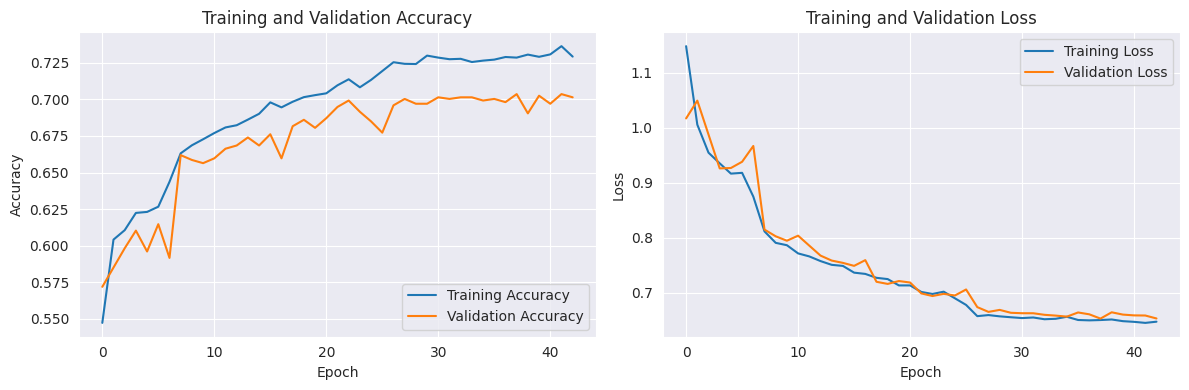


Training history plots displayed.


In [15]:
import matplotlib.pyplot as plt

# Assuming 'model' is compiled and 'train_generator', 'valid_generator'
# and 'callbacks_list' are defined from previous steps.

# Define the number of epochs
EPOCHS = 50 # Choose a reasonable number of epochs, Early Stopping will stop training if it converges earlier

# Calculate steps per epoch for generators
# steps_per_epoch = total_samples / batch_size
# For train_generator: len(train_df) / BATCH_SIZE
# For valid_generator: len(valid_df) / BATCH_SIZE
# Using ceil ensures you cover all samples, especially if len(df) is not divisible by BATCH_SIZE
# However, generators handle this automatically if steps_per_epoch is None or not specified,
# they will run for len(df) // BATCH_SIZE + 1 steps if needed.
# Specifying steps_per_epoch is often useful if you want to control the exact number of batches per epoch.
# Let's use the default behavior by not specifying steps_per_epoch explicitly for simplicity.
# If you want to specify:
# import math
# steps_per_epoch_train = math.ceil(len(train_df) / BATCH_SIZE)
# steps_per_epoch_valid = math.ceil(len(valid_df) / BATCH_SIZE)


print(f"Starting training for up to {EPOCHS} epochs...")

# Train the model
# The fit method returns a History object
history = model.fit(
    train_generator,
    # steps_per_epoch=steps_per_epoch_train, # Optional: Specify steps per epoch
    epochs=EPOCHS,
    validation_data=valid_generator,
    # validation_steps=steps_per_epoch_valid, # Optional: Specify validation steps
    callbacks=callbacks_list, # Use the defined callbacks (Early Stopping, ReduceLROnPlateau)
    verbose=1 # Display training progress
)

print("\nTraining finished.")

# --- Track and Visualize Training History ---

print("\nPlotting training history...")

# Get the history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs the model actually trained for (due to Early Stopping)
epochs_trained = len(history.history['loss'])
epochs_range = range(epochs_trained)

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)


# Plot training and validation loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout() # Adjust subplots to fit into figure area
plt.show()

print("\nTraining history plots displayed.")

* Report final Top-1 Accuracy, Precision, Recall, and F1-score on the held-out test set; include a confusion matrix.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'model' is trained (from the previous step)
# Assuming 'test_generator' is created (from the data augmentation step)

print("Evaluating the model on the test set...")

# 1. Evaluate the model to get the test loss and accuracy
# The evaluate method uses the generator to get batches of test data
loss, accuracy = model.evaluate(test_generator, verbose=0) # verbose=0 means no progress bar

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Top-1 Accuracy: {accuracy:.4f}")

# 2. Get predictions for the test set
# We need the predictions to compute Precision, Recall, F1-score, and the Confusion Matrix
# test_generator.reset() # It's often a good practice to reset the generator
predictions = model.predict(test_generator)

# The predictions are probabilities for each class
# To get the predicted class index, we take the argmax (index of the highest probability)
predicted_classes_indices = np.argmax(predictions, axis=1)

# Get the true labels from the test generator
# test_generator.classes contains the original class indices based on directory structure
# We need to get the true class indices corresponding to the order of samples in the generator
true_classes_indices = test_generator.classes
# Ensure the order of predictions matches the order of true labels
# The generator yields samples in a fixed order when shuffle=False
# We can get the order of filenames used by the generator
filenames = test_generator.filenames
# We need to map these filenames back to the original test_df labels
# Let's create a mapping from filename (full path) to true label index
label_map = {v: k for k, v in test_generator.class_indices.items()}
true_labels_from_filenames = [test_generator.class_indices[data[data['image'] == f]['label'].iloc[0]] for f in filenames]
true_labels_indices = np.array(true_labels_from_filenames)


# 3. Get the class names
class_names = list(test_generator.class_indices.keys())

# 4. Report Precision, Recall, and F1-score
# The classification_report function provides these metrics
print("\nClassification Report:")
# We need to ensure the true labels and predicted labels match in length and order
# The flow_from_dataframe with shuffle=False should provide samples in the order of the dataframe
# However, let's double check the lengths just in case
if len(true_labels_indices) == len(predicted_classes_indices):
     print(classification_report(true_labels_indices, predicted_classes_indices, target_names=class_names))
else:
     print("Warning: Mismatch between true labels and predicted labels length. Cannot generate classification report.")
     print(f"True labels length: {len(true_labels_indices)}")
     print(f"Predicted labels length: {len(predicted_classes_indices)}")
     # If there's a mismatch, the predict call might not have processed all samples correctly
     # This can sometimes happen with generators. One way to fix this is to predict
     # using the actual test_df and loading images explicitly, or ensuring generator settings are correct.
     # For now, we print a warning.


# 5. Generate and Plot Confusion Matrix
print("\nConfusion Matrix:")

# Compute the confusion matrix
cm = confusion_matrix(true_labels_indices, predicted_classes_indices)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nEvaluation complete.")

# **3. Explainability**

 • Generate Grad-CAM heat-maps for a few correctly and incorrectly classified images to illustrate model focus.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 # OpenCV is useful for image resizing and heatmap application
import pandas as pd # Needed if you didn't already load it

# Ensure you have OpenCV installed
!pip install opencv-python

# Assuming 'model' is your trained Keras model
# Assuming 'test_df' is your test DataFrame
# Assuming 'class_names' is the list of class names from earlier steps
# Assuming 'test_generator' is available for potential use in getting class indices

# --- Helper function to get Grad-CAM heatmap ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    # and the final output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Get the output of the last conv layer and the model predictions
        last_conv_layer_output, predictions = grad_model(img_array)
        # Compute the loss for the predicted class
        if pred_index is None:
            # If pred_index is not specified, take the index of the top predicted class
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradient of the top predicted class with respect to the output
    # of the last convolutional layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important" it is
    # with regard to the top predicted class, then sum all the channels to
    # obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, we normalize the heatmap between 0 and 1
    # and apply a ReLU
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# --- Helper function to display Grad-CAM ---
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)
    # Ensure image is not None (failed to load)
    if img is None:
        print(f"Warning: Could not load image for Grad-CAM display: {img_path}")
        return

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image from the RGB heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(
        jet_heatmap
    )
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save(cam_path) # Uncomment to save the image

    # Display the superimposed image
    # Note: Matplotlib expects RGB, OpenCV reads BGR. Convert before displaying
    plt.imshow(cv2.cvtColor(np.array(superimposed_img), cv2.COLOR_BGR2RGB))
    plt.axis("off")


# --- Select Images for Grad-CAM ---

# Get predicted class indices for the test set
# Ensure test_generator is reset and used for prediction to match order with true labels
# test_generator.reset() # Resetting again just in case
# predictions = model.predict(test_generator) # Already did this in previous cell
# predicted_classes_indices = np.argmax(predictions, axis=1) # Already did this

# Get true class indices (assuming you have true_labels_indices from the previous evaluation step)
# true_labels_indices = ... # Use the true_labels_indices from the evaluation step

# Get the list of image paths from the test generator (order matters)
# test_image_paths = test_generator.filenames # Use the filenames from the evaluation step

# Get class names
# class_names = list(test_generator.class_indices.keys()) # Use class_names from evaluation step


# Let's select a few correctly and incorrectly classified examples
correctly_classified_indices = np.where(predicted_classes_indices == true_labels_indices)[0]
incorrectly_classified_indices = np.where(predicted_classes_indices != true_labels_indices)[0]

num_examples_to_show = 3 # Number of examples of each category to display

print(f"\nGenerating Grad-CAM for {num_examples_to_show} correctly and incorrectly classified examples...")

# Find the name of the last convolutional layer
# You can inspect model.summary() or the model layers programmatically
# A common pattern is to find the last Conv2D layer before Flatten or GlobalAveragePooling
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    print("Error: Could not find a Conv2D layer in the model.")
else:
    print(f"Using last convolutional layer: {last_conv_layer_name}")

    # Display correctly classified examples
    print("\nCorrectly Classified Examples:")
    plt.figure(figsize=(15, num_examples_to_show * 3))
    for i in range(min(num_examples_to_show, len(correctly_classified_indices))):
        idx = correctly_classified_indices[i]
        img_path = test_image_paths[idx]
        true_label = class_names[true_labels_indices[idx]]
        predicted_label = class_names[predicted_classes_indices[idx]]

        # Load and preprocess the image for the model
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
        img_array = img_array / 255.0 # Rescale, must match generator

        # Generate heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Display original image and Grad-CAM
        plt.subplot(num_examples_to_show, 2, i * 2 + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

        plt.subplot(num_examples_to_show, 2, i * 2 + 2)
        save_and_display_gradcam(img_path, heatmap)
        plt.title("Grad-CAM")


    plt.tight_layout()
    plt.show()

    # Display incorrectly classified examples
    print("\nIncorrectly Classified Examples:")
    plt.figure(figsize=(15, num_examples_to_show * 3))
    for i in range(min(num_examples_to_show, len(incorrectly_classified_indices))):
        idx = incorrectly_classified_indices[i]
        img_path = test_image_paths[idx]
        true_label = class_names[true_labels_indices[idx]]
        predicted_label = class_names[predicted_classes_indices[idx]]

        # Load and preprocess the image for the model
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
        img_array = img_array / 255.0 # Rescale, must match generator

        # Generate heatmap
        # For incorrectly classified images, you might want to see the heatmap for the *predicted* class
        # Or you might want to see it for the *true* class to see why it didn't focus correctly.
        # Let's generate it for the predicted class for now.
        predicted_class_index = predicted_classes_indices[idx]
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=predicted_class_index)

        # Display original image and Grad-CAM
        plt.subplot(num_examples_to_show, 2, i * 2 + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

        plt.subplot(num_examples_to_show, 2, i * 2 + 2)
        save_and_display_gradcam(img_path, heatmap)
        plt.title("Grad-CAM")

    plt.tight_layout()
    plt.show()

print("\nGrad-CAM generation complete.")

Experiment Tracking using ML Flow
 • Conduct experiments with different models and track them using ML Flow.

# **3. Experiment Tracking using ML Flow**

* Conduct experiments with different models and track them using ML Flow.

In [ ]:
!pip install mlflow

import mlflow
import mlflow.tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator
import pandas as pd # Import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os # Import os for artifact paths

# Assume IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, num_classes are defined
# Assume train_df, valid_df, test_df are defined
# Assume train_generator, valid_generator, test_generator are defined

# --- MLflow Tracking Setup ---
# Set the tracking URI (where MLflow will store experiment data)
# For Colab, a simple way is to log to a local directory which you can then inspect
mlflow.set_tracking_uri("file:///content/mlruns")

# Set the experiment name
experiment_name = "ImageClassification_BaselineCNN"
mlflow.set_experiment(experiment_name)
print(f"MLflow Experiment set to: {experiment_name}")

# --- Define Hyperparameters ---
# Log these parameters with MLflow
params = {
    "img_height": IMG_HEIGHT,
    "img_width": IMG_WIDTH,
    "batch_size": BATCH_SIZE,
    "epochs": 50, # Maximum epochs, early stopping might stop earlier
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "loss_function": "categorical_crossentropy",
    "conv_layers": 4,
    "filters": [32, 64, 128, 256],
    "dense_units": 256,
    "activation": "relu",
    "output_activation": "softmax",
    "pooling": "MaxPooling2D",
    "pool_size": (2, 2),
    "early_stopping_patience": 5,
    "reduce_lr_patience": 3,
    "reduce_lr_factor": 0.1,
    # Augmentation parameters (log relevant ones used in ImageDataGenerator)
    "aug_rotation_range": 20,
    "aug_width_shift_range": 0.1,
    "aug_height_shift_range": 0.1,
    "aug_shear_range": 0.1,
    "aug_zoom_range": 0.1,
    "aug_horizontal_flip": True,
    "aug_brightness_range": "[0.8, 1.2]", # Log as string as list might be tricky
    "aug_fill_mode": "nearest"
}


# --- Start MLflow Run ---
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)
    print("Logged parameters to MLflow.")

    # --- Build and Compile the Model ---
    model = Sequential([
        Conv2D(filters=params['filters'][0], kernel_size=(3, 3), activation=params['activation'], padding='same',
               input_shape=(params['img_height'], params['img_width'], 3)),
        MaxPooling2D(pool_size=params['pool_size']),

        Conv2D(filters=params['filters'][1], kernel_size=(3, 3), activation=params['activation'], padding='same'),
        MaxPooling2D(pool_size=params['pool_size']),

        Conv2D(filters=params['filters'][2], kernel_size=(3, 3), activation=params['activation'], padding='same'),
        MaxPooling2D(pool_size=params['pool_size']),

        Conv2D(filters=params['filters'][3], kernel_size=(3, 3), activation=params['activation'], padding='same'),
        MaxPooling2D(pool_size=params['pool_size']),

        Flatten(),
        Dense(units=params['dense_units'], activation=params['activation']),
        # Optional: Add Dropout if needed based on overfitting (log dropout rate if used)
        # Dropout(0.5),
        Dense(units=num_classes, activation=params['output_activation'])
    ])

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer,
                  loss=params['loss_function'],
                  metrics=['accuracy'])

    print("Model built and compiled.")
    model.summary() # Optional: print summary, might not be logged by default

    # --- Define Callbacks ---
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=params['early_stopping_patience'],
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=params['reduce_lr_factor'],
        patience=params['reduce_lr_patience'],
        min_lr=0.00001
    )

    callbacks_list = [early_stopping, reduce_lr]

    # --- Train the Model ---
    print(f"\nStarting training for up to {params['epochs']} epochs...")

    history = model.fit(
        train_generator,
        epochs=params['epochs'],
        validation_data=valid_generator,
        callbacks=callbacks_list,
        verbose=1
    )

    print("\nTraining finished.")

    # --- Log Training Metrics (Loss and Accuracy per Epoch) ---
    # MLflow can log metrics iteratively within model.fit by adding a custom callback,
    # or you can log the final history metrics after training. Let's log the final ones.
    epochs_trained = len(history.history['loss'])
    mlflow.log_metric("epochs_trained", epochs_trained)
    mlflow.log_metric("final_train_loss", history.history['loss'][-1])
    mlflow.log_metric("final_train_accuracy", history.history['accuracy'][-1])
    mlflow.log_metric("final_val_loss", history.history['val_loss'][-1])
    mlflow.log_metric("final_val_accuracy", history.history['val_accuracy'][-1])
    print("Logged final training history metrics to MLflow.")

    # --- Plot and Log Training History ---
    print("Plotting and logging training history...")
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs_trained), history.history['accuracy'], label='Training Accuracy')
    plt.plot(range(epochs_trained), history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs_trained), history.history['loss'], label='Training Loss')
    plt.plot(range(epochs_trained), history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    history_plot_path = "training_history.png"
    plt.savefig(history_plot_path)
    mlflow.log_artifact(history_plot_path)
    plt.close() # Close the plot to free memory
    print("Logged training history plot.")


    # --- Evaluate the Model on the Test Set ---
    print("\nEvaluating the model on the test set...")

    loss, accuracy = model.evaluate(test_generator, verbose=0)
    mlflow.log_metric("test_loss", loss)
    mlflow.log_metric("test_top1_accuracy", accuracy)
    print(f"Logged Test Loss: {loss:.4f}")
    print(f"Logged Test Top-1 Accuracy: {accuracy:.4f}")

    # Get predictions and true labels for classification report and confusion matrix
    # Ensure test_generator is reset for consistent order
    test_generator.reset()
    predictions = model.predict(test_generator)
    predicted_classes_indices = np.argmax(predictions, axis=1)

    # Re-calculate true labels based on filenames to match prediction order
    test_image_paths = test_generator.filenames
    class_names = list(test_generator.class_indices.keys())
    # Ensure you have the original 'data' or 'test_df' DataFrame available to map filenames to labels
    # Assuming 'data' df from earlier cells is available globally or passed
    # If not, you might need to load or access test_df here
    true_labels_from_filenames = [test_generator.class_indices[test_df[test_df['image'] == f]['label'].iloc[0]] for f in test_image_paths]
    true_labels_indices = np.array(true_labels_from_filenames)


    # Report Precision, Recall, and F1-score
    if len(true_labels_indices) == len(predicted_classes_indices):
        report = classification_report(true_labels_indices, predicted_classes_indices, target_names=class_names, output_dict=True)
        # Log the report metrics individually
        for class_name, metrics in report.items():
            if isinstance(metrics, dict): # Metrics for individual classes
                 mlflow.log_metric(f"test_{class_name}_precision", metrics["precision"])
                 mlflow.log_metric(f"test_{class_name}_recall", metrics["recall"])
                 mlflow.log_metric(f"test_{class_name}_f1-score", metrics["f1-score"])
                 mlflow.log_metric(f"test_{class_name}_support", metrics["support"])
            else: # Aggregated metrics (accuracy, macro avg, weighted avg)
                 mlflow.log_metric(f"test_{class_name.replace(' ', '_')}", metrics) # Replace space for metric name
        print("\nLogged Classification Report metrics to MLflow.")
        print(classification_report(true_labels_indices, predicted_classes_indices, target_names=class_names)) # Print report to console

    else:
         print("Warning: Mismatch between true labels and predicted labels length. Cannot log full classification report.")


    # Generate and Plot Confusion Matrix
    print("\nLogging Confusion Matrix...")
    cm = confusion_matrix(true_labels_indices, predicted_classes_indices)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    confusion_matrix_path = "confusion_matrix.png"
    plt.savefig(confusion_matrix_path)
    mlflow.log_artifact(confusion_matrix_path)
    plt.close() # Close the plot
    print("Logged confusion matrix plot.")


    # --- Log the Keras Model ---
    print("\nLogging the trained model...")
    # Save the model directly using mlflow.tensorflow.log_model
    # This saves the model in a format that MLflow understands (TensorFlow SavedModel format)
    mlflow.tensorflow.log_model(
        model=model,
        artifact_path="model", # Directory within the run's artifacts
        # You can add a signature if you know the input/output shapes
        # signature=mlflow.models.infer_signature(input_example, model.predict(input_example))
        # input_example=train_generator[0][0] # Use a sample input batch
    )
    print("Logged the trained model.")

    # --- Optional: Log Sample Predictions or Grad-CAMs as Artifacts ---
    # You could select a few test images, generate predictions/Grad-CAMs,
    # save them as image files, and log those image files as artifacts.
    # This requires implementing the Grad-CAM logic within the run context if you want it logged per run.
    # For simplicity, this is not included in this base MLflow integration.


print("\nMLflow run finished.")
print(f"MLflow data logged to: {mlflow.get_tracking_uri()}")

# To view the MLflow UI in Colab:
# Run the following command in a new code cell:
# !pip install pyngrok -q
# from pyngrok import ngrok
# import os
# # Terminate any previous ngrok tunnels
# !kill $(ps aux | grep 'ngrok' | awk '{print $2}') > /dev/null 2>&1
# # Replace /content/mlruns with your MLflow tracking URI path
# TUNNEL_URL = ngrok.connect(5000, bind_tls=True)
# print(f"MLflow UI running at: {TUNNEL_URL.public_url}")
# !mlflow ui --backend-store-uri "file:///content/mlruns" -p 5000 &

# **3. (Optional) Transfer Learning**

* Replace the baseline with a frozen backbone such as ResNet-18 or EfficientNet-B0 and fine-tune the head.

In [ ]:
!pip install mlflow # Ensure mlflow is installed
!pip install opencv-python # Ensure opencv-python is installed for Grad-CAM

import mlflow
import mlflow.tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0 # Import pre-trained models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import cv2 # Import cv2 for image handling in Grad-CAM


# Assume IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, num_classes are defined
# Assume train_df, valid_df, test_df are defined
# Assume train_generator, valid_generator, test_generator are defined (already have rescale=1./255)
# For pre-trained models like ResNet or EfficientNet, you might need to adjust the preprocessing
# specific to the pre-trained model (e.g., using preprocess_input).
# However, since our ImageDataGenerator already rescales to [0, 1],
# and EfficientNet/ResNet expect inputs normalized to [0, 1] or [-1, 1],
# the current rescaling in the generator is a reasonable starting point.
# If using models that expect [-1, 1], you might need to use a preprocessing function.
# Let's stick with the [0, 1] scaled data from the generators for simplicity now.


# --- MLflow Tracking Setup ---
mlflow.set_tracking_uri("file:///content/mlruns")
# Create a new experiment for fine-tuning or use the same one
experiment_name = "ImageClassification_FineTuning" # Or keep "ImageClassification_BaselineCNN"
mlflow.set_experiment(experiment_name)
print(f"MLflow Experiment set to: {experiment_name}")

# --- Define Hyperparameters for Fine-tuning ---
params_ft = {
    "model_type": "EfficientNetB0", # Or "ResNet50"
    "img_height": IMG_HEIGHT,
    "img_width": IMG_WIDTH,
    "batch_size": BATCH_SIZE,
    "epochs_phase1": 10, # Epochs for training the head
    "epochs_phase2": 20, # Epochs for fine-tuning
    "learning_rate_phase1": 0.001, # Higher LR for the head
    "learning_rate_phase2": 0.0001, # Very low LR for fine-tuning
    "optimizer": "Adam",
    "loss_function": "categorical_crossentropy",
    "dense_units": 256, # Units in the new Dense layer
    "activation": "relu",
    "output_activation": "softmax",
    "early_stopping_patience_phase1": 3,
    "early_stopping_patience_phase2": 5,
    "reduce_lr_patience_phase1": 2,
    "reduce_lr_patience_phase2": 3,
    "reduce_lr_factor": 0.1,
    # Augmentation parameters (referencing parameters from the generator setup)
    "aug_rotation_range": 20,
    "aug_width_shift_range": 0.1,
    "aug_height_shift_range": 0.1,
    "aug_shear_range": 0.1,
    "aug_zoom_range": 0.1,
    "aug_horizontal_flip": True,
    "aug_brightness_range": "[0.8, 1.2]",
    "aug_fill_mode": "nearest"
}


# --- Start MLflow Run for Fine-tuning ---
with mlflow.start_run():
    # Log the hyperparameters for fine-tuning
    mlflow.log_params(params_ft)
    print("Logged parameters for fine-tuning to MLflow.")

    # --- Load Pre-trained Backbone ---
    if params_ft['model_type'] == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, # exclude classification head
                              input_shape=(params_ft['img_height'], params_ft['img_width'], 3))
        last_conv_layer_name = "conv5_block3_out" # Typical last conv layer for ResNet50
    elif params_ft['model_type'] == "EfficientNetB0":
        base_model = EfficientNetB0(weights='imagenet', include_top=False, # exclude classification head
                                   input_shape=(params_ft['img_height'], params_ft['img_width'], 3))
        last_conv_layer_name = "top_conv" # Typical last conv layer for EfficientNetB0 (check summary if needed)
    else:
        raise ValueError(f"Unsupported model_type: {params_ft['model_type']}")

    print(f"Loaded pre-trained {params_ft['model_type']} model.")

    # --- Freeze the Backbone ---
    base_model.trainable = False
    print("Frozen the base model layers.")

    # --- Add New Classification Head ---
    x = base_model.output
    # Add a Global Average Pooling layer instead of Flatten for CNNs
    # This is common practice after the last conv layer in classification tasks
    x = GlobalAveragePooling2D()(x)
    # Add Dense layers
    x = Dense(params_ft['dense_units'], activation=params_ft['activation'])(x)
    # Optional: Add Dropout
    # x = Dropout(0.5)(x)
    predictions_output = Dense(num_classes, activation=params_ft['output_activation'])(x)

    # Create the new model
    model_ft = Model(inputs=base_model.input, outputs=predictions_output)

    print("\nNew classification head added.")
    model_ft.summary() # Print the summary of the new model


    # --- Phase 1: Train Classification Head ---
    print("\n--- Phase 1: Training Classification Head ---")

    optimizer_phase1 = Adam(learning_rate=params_ft['learning_rate_phase1'])
    model_ft.compile(optimizer=optimizer_phase1,
                     loss=params_ft['loss_function'],
                     metrics=['accuracy'])

    callbacks_phase1 = [
        EarlyStopping(monitor='val_loss', patience=params_ft['early_stopping_patience_phase1'], restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=params_ft['reduce_lr_factor'], patience=params_ft['reduce_lr_patience_phase1'], min_lr=0.000001)
    ]

    history_phase1 = model_ft.fit(
        train_generator,
        epochs=params_ft['epochs_phase1'],
        validation_data=valid_generator,
        callbacks=callbacks_phase1,
        verbose=1
    )
    print("\nPhase 1 finished.")

    # Log Phase 1 Metrics
    mlflow.log_metric("phase1_epochs_trained", len(history_phase1.history['loss']))
    mlflow.log_metric("phase1_final_train_loss", history_phase1.history['loss'][-1])
    mlflow.log_metric("phase1_final_train_accuracy", history_phase1.history['accuracy'][-1])
    mlflow.log_metric("phase1_final_val_loss", history_phase1.history['val_loss'][-1])
    mlflow.log_metric("phase1_final_val_accuracy", history_phase1.history['val_accuracy'][-1])
    print("Logged Phase 1 metrics.")

    # --- Phase 2: Fine-tuning (Unfreeze some layers) ---
    print("\n--- Phase 2: Fine-tuning Backbone ---")

    # Unfreeze the base model
    base_model.trainable = True

    # It's common to unfreeze only the top layers, not the entire base_model
    # For example, if using ResNet50, you might unfreeze layers after a certain block
    # Or, you can iterate through layers and unfreeze a percentage or specific layers by name

    # Example: Unfreeze top layers in EfficientNetB0 (adjust based on model summary)
    # EfficientNet layers are often named with blocks. Let's unfreeze the last few blocks.
    if params_ft['model_type'] == "EfficientNetB0":
         # Find the percentage of layers to unfreeze (e.g., last 30%)
         percentage_to_unfreeze = 0.3
         num_layers_to_unfreeze = int(len(base_model.layers) * percentage_to_unfreeze)
         print(f"Unfreezing the last {num_layers_to_unfreeze} layers of the base model for fine-tuning.")
         for layer in base_model.layers[:-num_layers_to_unfreeze]:
             layer.trainable = False
    # If using ResNet50, you'd do something similar, perhaps based on blocks.
    # This requires inspecting the model summary to know layer names/indices.
    # For simplicity here, if not EfficientNet, we'll assume entire base_model is unfrozen (less common but simple)
    # A more controlled approach is recommended for actual fine-tuning.


    # Re-compile the model with a very low learning rate
    optimizer_phase2 = Adam(learning_rate=params_ft['learning_rate_phase2'])
    model_ft.compile(optimizer=optimizer_phase2, # Use the new optimizer with low LR
                     loss=params_ft['loss_function'],
                     metrics=['accuracy'])

    # Use new Early Stopping and Reduce LR patience/factors if defined, or reuse
    callbacks_phase2 = [
        EarlyStopping(monitor='val_loss', patience=params_ft['early_stopping_patience_phase2'], restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=params_ft['reduce_lr_factor'], patience=params_ft['reduce_lr_patience_phase2'], min_lr=0.0000001) # Even lower min_lr
    ]

    # Continue training from where Phase 1 left off
    history_phase2 = model_ft.fit(
        train_generator,
        epochs=params_ft['epochs_phase1'] + params_ft['epochs_phase2'], # Total epochs count
        initial_epoch=len(history_phase1.history['loss']), # Start from the epoch after Phase 1 ended
        validation_data=valid_generator,
        callbacks=callbacks_phase2,
        verbose=1
    )
    print("\nPhase 2 finished.")

    # Combine history for plotting and logging
    history_combined = {}
    for key in history_phase1.history.keys():
        history_combined[key] = history_phase1.history[key] + history_phase2.history[key]

    # Log Phase 2 Metrics
    mlflow.log_metric("phase2_epochs_trained", len(history_phase2.history['loss']))
    mlflow.log_metric("phase2_final_train_loss", history_combined['loss'][-1])
    mlflow.log_metric("phase2_final_train_accuracy", history_combined['accuracy'][-1])
    mlflow.log_metric("phase2_final_val_loss", history_combined['val_loss'][-1])
    mlflow.log_metric("phase2_final_val_accuracy", history_combined['val_accuracy'][-1])
    print("Logged Phase 2 metrics.")


    # --- Plot and Log Combined Training History ---
    print("\nPlotting and logging combined training history...")
    epochs_combined = len(history_combined['loss'])
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs_combined), history_combined['accuracy'], label='Training Accuracy')
    plt.plot(range(epochs_combined), history_combined['val_accuracy'], label='Validation Accuracy')
    plt.axvline(x=len(history_phase1.history['loss'])-1, color='gray', linestyle='--', label='End of Phase 1') # Mark phase transition
    plt.legend(loc='lower right')
    plt.title('Combined Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs_combined), history_combined['loss'], label='Training Loss')
    plt.plot(range(epochs_combined), history_combined['val_loss'], label='Validation Loss')
    plt.axvline(x=len(history_phase1.history['loss'])-1, color='gray', linestyle='--', label='End of Phase 1') # Mark phase transition
    plt.legend(loc='upper right')
    plt.title('Combined Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    history_plot_path_ft = "fine_tuning_history.png"
    plt.savefig(history_plot_path_ft)
    mlflow.log_artifact(history_plot_path_ft)
    plt.close()
    print("Logged combined training history plot.")


    # --- Evaluate the Fine-tuned Model on the Test Set ---
    print("\nEvaluating the fine-tuned model on the test set...")

    loss_ft, accuracy_ft = model_ft.evaluate(test_generator, verbose=0)
    mlflow.log_metric("test_loss_ft", loss_ft)
    mlflow.log_metric("test_top1_accuracy_ft", accuracy_ft)
    print(f"Logged Fine-tuned Test Loss: {loss_ft:.4f}")
    print(f"Logged Fine-tuned Test Top-1 Accuracy: {accuracy_ft:.4f}")

    # Get predictions and true labels for classification report and confusion matrix
    test_generator.reset()
    predictions_ft = model_ft.predict(test_generator)
    predicted_classes_indices_ft = np.argmax(predictions_ft, axis=1)

    # Use the same true_labels_indices calculated earlier (assuming it's available in scope)
    # Or recalculate if needed based on test_df and test_generator.filenames
    # true_labels_indices = ... # Ensure this is correctly defined and available


    # Report Precision, Recall, and F1-score for Fine-tuned Model
    if len(true_labels_indices) == len(predicted_classes_indices_ft):
        report_ft = classification_report(true_labels_indices, predicted_classes_indices_ft, target_names=class_names, output_dict=True)
        for class_name, metrics in report_ft.items():
             if isinstance(metrics, dict):
                 mlflow.log_metric(f"test_ft_{class_name}_precision", metrics["precision"])
                 mlflow.log_metric(f"test_ft_{class_name}_recall", metrics["recall"])
                 mlflow.log_metric(f"test_ft_{class_name}_f1-score", metrics["f1-score"])
                 mlflow.log_metric(f"test_ft_{class_name}_support", metrics["support"])
             else:
                 mlflow.log_metric(f"test_ft_{class_name.replace(' ', '_')}", metrics)
        print("\nLogged Fine-tuned Classification Report metrics to MLflow.")
        print(classification_report(true_labels_indices, predicted_classes_indices_ft, target_names=class_names))

    else:
         print("Warning: Mismatch in test set length. Cannot log full fine-tuned classification report.")


    # Generate and Plot Confusion Matrix for Fine-tuned Model
    print("\nLogging Fine-tuned Confusion Matrix...")
    cm_ft = confusion_matrix(true_labels_indices, predicted_classes_indices_ft)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Fine-tuned Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    confusion_matrix_path_ft = "confusion_matrix_fine_tuned.png"
    plt.savefig(confusion_matrix_path_ft)
    mlflow.log_artifact(confusion_matrix_path_ft)
    plt.close()
    print("Logged fine-tuned confusion matrix plot.")


    # --- Log the Fine-tuned Keras Model ---
    print("\nLogging the fine-tuned model...")
    mlflow.tensorflow.log_model(
        model=model_ft,
        artifact_path="model_fine_tuned", # Separate artifact path
        # input_example=train_generator[0][0]
    )
    print("Logged the fine-tuned model.")


print("\nMLflow fine-tuning run finished.")
print(f"MLflow data logged to: {mlflow.get_tracking_uri()}")

# To view the MLflow UI in Colab:
# Run the following command in a new code cell if the UI isn't already running:
# !pip install pyngrok -q
# from pyngrok import ngrok
# import os
# # Terminate any previous ngrok tunnels
# !kill $(ps aux | grep 'ngrok' | awk '{print $2}') > /dev/null 2>&1
# # Replace /content/mlruns with your MLflow tracking URI path
# TUNNEL_URL = ngrok.connect(5000, bind_tls=True)
# print(f"MLflow UI running at: {TUNNEL_URL.public_url}")
# !mlflow ui --backend-store-uri "file:///content/mlruns" -p 5000 &



* Compare metrics with the scratch CNN.
